In [18]:
# In Kaggle run the following line:
# !pip install --upgrade tensorflow
#then select `restart and clear all cells` and DO NOT FACTORY RESET

# Imports

In [19]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,\
    Embedding, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import sparse_categorical_accuracy
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import Accuracy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import re
import nltk
import matplotlib.pyplot as plt
from keras.preprocessing import text
from keras.preprocessing.sequence import skipgrams
from IPython.display import SVG
from keras.utils import plot_model
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation
from gensim.models import Word2Vec


# Load in Data
### Insert your relative file path here

In [20]:
df = pd.read_csv('../Data/df_with_section_names.csv')

In [21]:
df.head()

,Unnamed: 0,Document,Category
0,0,see latest charts maps coronavirus cases death...,Opinion
1,1,biggest increases come groups past far less li...,Opinion
2,2,miguel cardona education secretary said reopen...,Opinion
3,3,mohamed morsi egypt first democratically elect...,Sports
4,4,see full results maps district columbia electi...,Sports


In [22]:
df = df.drop(columns='Unnamed: 0')

In [23]:
df['Category'] = df['Category'].str.lower()

In [24]:
df.head()

,Document,Category
0,see latest charts maps coronavirus cases death...,opinion
1,biggest increases come groups past far less li...,opinion
2,miguel cardona education secretary said reopen...,opinion
3,mohamed morsi egypt first democratically elect...,sports
4,see full results maps district columbia electi...,sports


### Same process as CBOW: tokenize, sequence, pad, train, analyze

In [25]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [26]:
sampled_test = df.sample(n=1000, random_state=42)

In [27]:
corpus = sampled_test['Document'].tolist()

In [28]:
norm_corpus = normalize_corpus(corpus)
norm_corpus;

### Skip Gram

In [29]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_corpus)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1 
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_corpus]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 5463
Vocabulary Sample: [('county', 1), ('see', 2), ('maps', 3), ('u', 4), ('covid', 5), ('cases', 6), ('election', 7), ('deaths', 8), ('latest', 9), ('charts', 10)]


In [30]:
# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(primary (371), klan (4616)) -> 0
(district (29), dogs (1940)) -> 0
(district (29), afford (2097)) -> 0
(sixth (724), house (38)) -> 1
(house (38), district (29)) -> 1
(california (47), credit (4090)) -> 0
(nan (552), use (256)) -> 0
(results (12), wars (1326)) -> 0
(district (29), results (12)) -> 1
(nan (552), california (47)) -> 1


In [31]:
# Train neural net with random sample 
from keras.layers import concatenate, Reshape
from keras.layers import Dense
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Input, Dot
from keras.models import Model


In [32]:
word_input = Input(shape=(1,))
word_embedding = Embedding(vocab_size, embed_size,
                           embeddings_initializer="glorot_uniform")(word_input)
word_reshape = Reshape((embed_size,))(word_embedding)
word_model = Model(inputs=word_input, outputs=word_reshape)

# Build context model
context_input = Input(shape=(1,))
context_embedding = Embedding(vocab_size, embed_size,
                              embeddings_initializer="glorot_uniform")(context_input)
context_reshape = Reshape((embed_size,))(context_embedding)
context_model = Model(inputs=context_input, outputs=context_reshape)

# Dot product layer
dot_product = Dot(axes=-1)([word_model.output, context_model.output])

# Dense layer
dense_layer = Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid")(dot_product)

# Combine the models
model = Model(inputs=[word_input, context_input], outputs=dense_layer)

# Compile the model
model.compile(loss="mean_squared_error", optimizer="rmsprop")

# Display model summary
print(model.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 1, 100)               546300    ['input_3[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, 1, 100)               546300    ['input_4[0][0]']             
                                                                                            

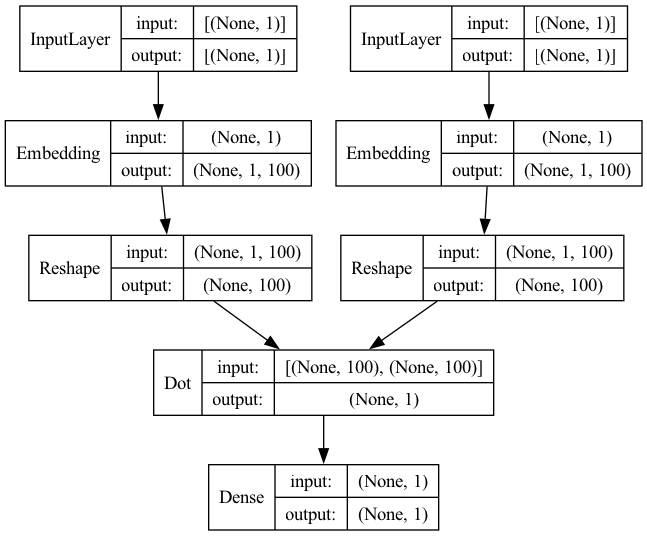

In [33]:
# visualize model structure
# Save model summary to a file
model_summary_file = "model_summary.txt"
with open(model_summary_file, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

# Visualize model structure and save to an image file
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=False, rankdir='TB')

In [34]:
for epoch in range(1, 6):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs


Epoch: 1 Loss: 249.9982187896967
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 249.98573450744152
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 249.81721168756485
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 4 Loss: 246.01240907609463
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 5 Loss: 234.9946151226759


In [35]:
# Access layers directly by index
word_input_layer = model.input[0]
word_embedding_layer = model.layers[2]  # Assuming Embedding layer is the third layer in the model

# You can get the weights of the embedding layer as follows
weights = word_embedding_layer.get_weights()[0][1:]

In [36]:
# view weights
print(weights.shape)
pd.DataFrame(weights, index=id2word.values()).head()

(5462, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
county,-0.212806,-0.268308,-0.375599,0.067041,-0.247995,0.277973,-0.197431,-0.091976,0.237942,0.026249,...,0.049657,0.056925,0.238963,0.118580,-0.081180,0.167206,-0.049963,0.019246,0.179299,0.264226
see,-0.231141,-0.200414,-0.418148,0.038815,-0.293958,0.125583,-0.150034,0.097865,0.190969,-0.011071,...,-0.061697,0.187919,0.239107,-0.096309,0.015448,0.123405,-0.057789,0.129739,0.041046,0.174658
maps,-0.195080,-0.220854,-0.437092,0.040231,-0.275063,0.121511,-0.222333,0.086931,0.280029,-0.082092,...,-0.022175,0.118048,0.209236,-0.098003,0.025229,0.118876,-0.080740,0.138461,0.138353,0.193011
u,-0.045738,-0.034792,-0.049112,0.013692,-0.007670,-0.022076,-0.033753,0.018317,0.004176,-0.015887,...,-0.039890,0.026072,0.049572,-0.029618,0.024229,0.032666,-0.049143,-0.013229,0.019479,0.064592
covid,-0.135534,-0.169098,-0.265470,0.065723,-0.174744,0.225586,-0.134350,-0.096144,0.172257,-0.018413,...,-0.009919,0.037737,0.206052,0.074688,-0.046997,0.152645,-0.072119,-0.029834,0.132901,0.187390


In [37]:
# Find closest distance neighbors with clustering

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['politics', 'covid', 'united', 'trump', 'russia', 'country', 'war','county']}

similar_words

(5462, 5462)


{'politics': ['symptoms', 'justices', 'including', 'britain', 'entertainment'],
 'covid': ['charts', 'latest', 'deaths', 'hospitalizations', 'cases'],
 'united': ['unruly', 'ban', 'atlantic', 'topped', 'psychedelic'],
 'trump': ['upends', 'tycoon', 'smartphone', 'demanding', 'bar'],
 'russia': ['blames', 'called', 'republicans', 'upended', 'insurers'],
 'country': ['rollbacks', 'earlier', 'conduct', 'cooking', 'stayed'],
 'war': ['loyalties', 'followed', 'pickleball', 'documenting', 'replenish'],
 'county': ['deaths', 'hospitalizations', 'cases', 'covid', 'charts']}

### Visualize with `t-SNE` which stands for `t-distributed stochastic neighbor embedding` a popular dimensionality reduction technique to visualize higher dimension spaces in lower dimensions (i.e. 2-D)

Total words: 48 	Word Embedding shapes: (48, 100)


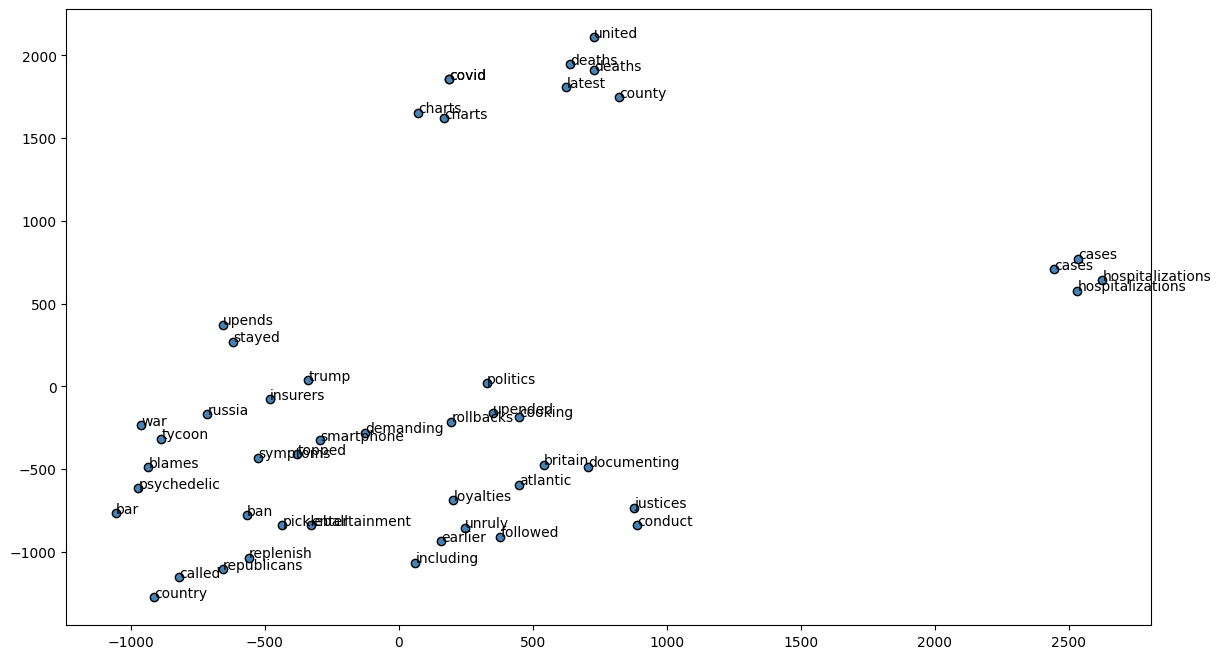

In [38]:
words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

### Scale up with gensim

In [39]:
# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

feature_size = 100  # You can adjust the feature size as needed
window_context = 5
min_word_count = 1
sample = 1e-3

w2v_model = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=feature_size,
    window=window_context,
    min_count=min_word_count,
    sample=sample,
    epochs=50  # 'iter' is replaced with 'epochs' in more recent versions
)


# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['politics', 'covid', 'united', 'trump', 'russia', 'country', 'war','county']}
similar_words

{'politics': ['opposition', 'cities', 'reshape', 'giuliani', 'requirement'],
 'covid': ['clay', 'macon', 'personhood', 'missouri', 'proof'],
 'united': ['deadbeat', 'ponder', 'metrics', 'removes', 'customs'],
 'trump': ['course', 'bridge', 'fantasy', 'indictment', 'scope'],
 'russia': ['invasion', 'ukraine', 'beta', 'warning', 'ii'],
 'country': ['still', 'across', 'public', 'work', 'back'],
 'war': ['cold', 'reminiscent', 'proceed', 'russia', 'committed'],
 'county': ['fillmore', 'covington', 'gorda', 'scott', 'covid']}

### Comparing, we have some better results but also some more peculiar results (gensim pulls from its library)

#### Visualize as before with tSNE

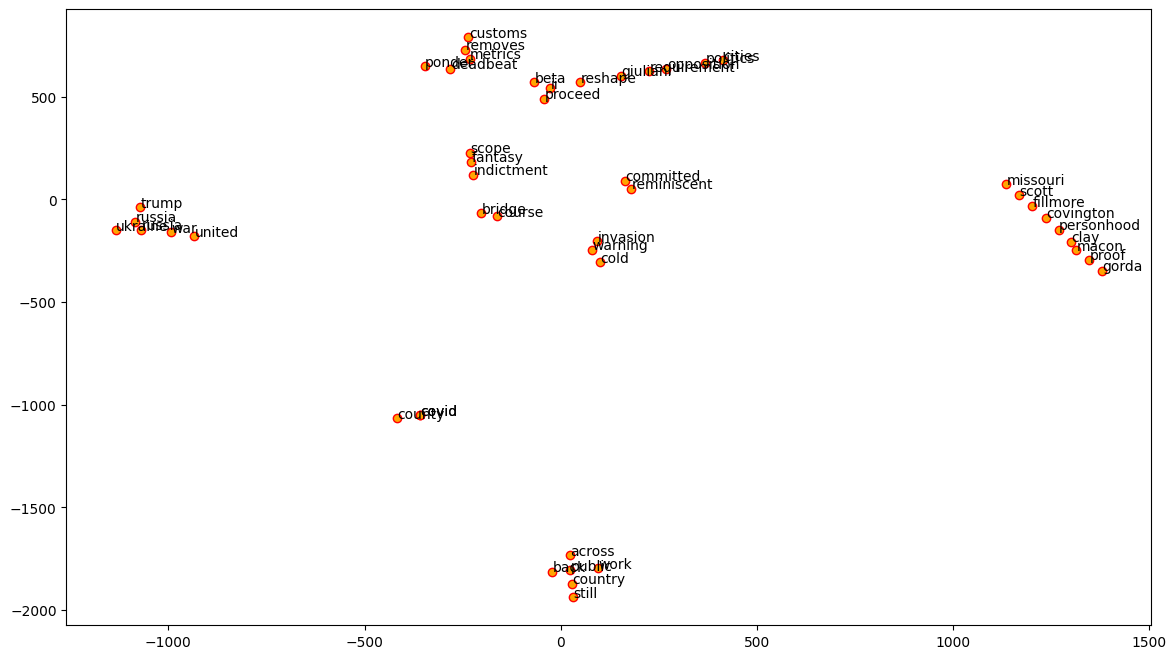

In [40]:
words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')


### Building a larger scale model based on word2vec

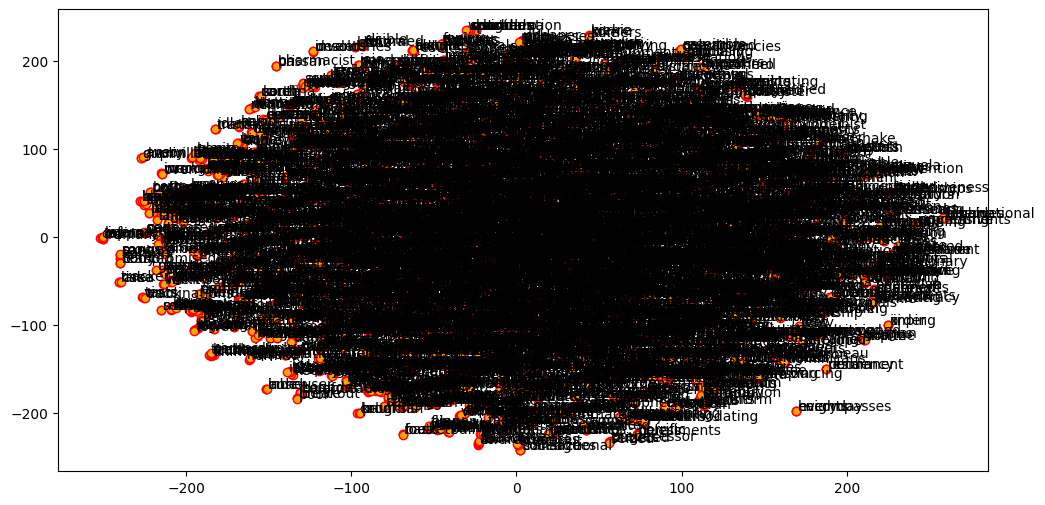

In [41]:
# Tokenize the corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Set values for various parameters
feature_size = 10  # Word vector dimensionality  
window_context = 10  # Context window size                                                                                    
min_word_count = 1  # Minimum word count                        
sample = 1e-3  # Downsample setting for frequent words

# Build word2vec model
w2v_model = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=feature_size,
    window=window_context,
    min_count=min_word_count,
    sample=sample,
    epochs=100  # 'iter' is replaced with 'epochs' in more recent versions
)

# Visualize embeddings using t-SNE
from sklearn.manifold import TSNE

words = w2v_model.wv.index_to_key
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)

# Plot the embeddings
plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(words, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

plt.show()

### Far too dense to derive any meaning from this cluster

In [42]:
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            if hasattr(model, 'wv'):
                feature_vector = np.add(feature_vector, model.wv[word])
            else:
                feature_vector = np.add(feature_vector, model[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key) if hasattr(model, 'wv') else set(model.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                for tokenized_sentence in corpus]
    return np.array(features)

# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)


,0,1,2,3,4,5,6,7,8,9
0,-2.381734,-4.155153,-0.150260,-0.513285,3.969174,-0.978509,0.573098,3.530222,-5.408979,-2.570837
1,0.972168,-1.076894,-1.085628,-1.596573,-2.727715,3.476526,2.089402,2.551253,-1.805523,-0.065970
2,1.102626,0.220660,0.339947,0.644199,0.311447,0.586283,1.378053,0.215419,-1.427156,0.535999
3,-4.963280,4.833022,2.177123,-0.773456,1.645505,0.825243,2.336976,2.702069,-8.764054,-0.360119
4,2.988217,0.694936,0.252447,1.471063,-0.784592,0.003292,1.976784,0.555381,-1.312967,0.343793
...,...,...,...,...,...,...,...,...,...,...
995,-2.556763,-1.738031,-0.317035,-1.376770,2.872033,-0.108431,0.548340,2.912483,-5.841493,-1.665422
996,3.358971,-2.903865,-0.380589,0.495642,-1.431189,-0.701785,2.496293,0.623494,-0.873271,-1.157256
997,-4.903783,5.028525,2.425027,-1.173177,1.600003,0.769897,2.360119,3.310809,-8.857090,0.074703
998,0.338810,0.376847,-0.193444,0.754533,0.781669,-0.419144,1.624094,0.743843,-1.165054,-0.202182


### Time to Cluster to form buckets of bins for our categories!

In [43]:
ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,see latest charts maps coronavirus cases death...,opinion,16.0
1,biggest increases come groups past far less li...,opinion,20.0
2,miguel cardona education secretary said reopen...,opinion,19.0
3,mohamed morsi egypt first democratically elect...,sports,9.0
4,see full results maps district columbia electi...,sports,7.0
...,...,...,...
25505,abdicated parental rights duties new societal ...,health,NaN
25506,overcame desperation felt stepping congress st...,the upshot,NaN
25507,former n f l wide receiver joined premier lacr...,world,NaN
25508,placing tracking devices netbooks discarded ce...,opinion,NaN


### Wow! That's a lot of ClusterLabels...which makes sense we have over 25k unique rows!!!

#### Use PCA to reduce dimensionality!

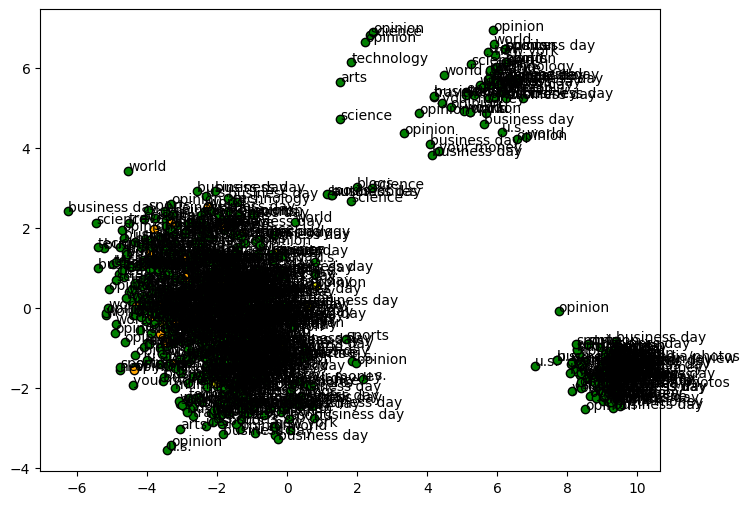

In [44]:
pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(df['Category'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'yellow' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')


### In the same way as CBOW, we look at our graphs, find common words associated with bias, and create labeling functions (keyword functions) for those words and perform another iteration of the Snorkel labeling script in order to see what effect these newly created functions have upon our data when trained on our hand-labeled training set. We also use Cosine Similarity to this end. 